# **BERT - Enfin un tutoriel simple et rapide !** - [lire l'article](https://inside-machinelearning.com/bert-enfin-un-tutoriel-simple-et-rapide/)

[Read the post in English](https://inside-machinelearning.com/en/bert-the-perfect-tutorial-to-easily-use-it/)

Aujourd'hui, nous allons voir avec ce tutoriel comment **implémenter simplement et rapidement le Transformer BERT**.

BERT est **un modèle de Deep Learning** lancé fin 2019 par **Google**. C'est un **Transformer**, un type bien spécifique de **réseaux de neurones**. D'ailleurs BERT signifie "*Bidirectional Encoder Representations from Transformers*" littéralement "*Représentations d'encodeurs bidirectionnels à partir de transformateurs*".

Mais dans ce article nous n'allons pas voir en détails ce qu'est un Transformer... je vous propose plutôt de voir **comment implémenter, entraîner et utiliser facilement BERT !**

Pour cela on va prendre **un problème classique de NLP** que vous connaissez sûrement : **la classification de critiques de cinéma**.

Notre modèle de Deep Learning va pouvoir **lire une critique** puis **comprendre si elle est positive ou négative**.

C'est d'ailleurs ce qu'on a déjà fait dans [cet article](https://inside-machinelearning.com/un-modele-classification-binaire-en-nlp/) avec **un modèle de Deep Learning plus basique**... maintenant **on passe à l'étape supérieur** en le faisant avec **BERT !**

# **Préparer les données**

## **Charger le modèle et les données**

**Tout d'abord**, nous allons utiliser **la librairie** *tensorflow_hub*.

C'est une librairie qui permet **d'accéder à des modèles disponible** sur [TensorFlow Hub](https://tfhub.dev).

En fait, **TensorFlow Hub** est un site répertoriant **des modèles officiels de Machine Learning préentraînés** aussi bien dans le domaine du **NLP** mais pour **la Vision par ordinateur** et bien d'autres.

On va donc utiliser *tensorflow_hub* pour charger **BERT**. Différent type de BERT existe, on va prendre **le plus léger** "*bert_en_uncased_L-12_H-768_A-12*" pour que l'exécution se fasse **rapidement !**

In [ ]:
import tensorflow_hub as hub

module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
#module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"

bert_layer = hub.KerasLayer(module_url, trainable=True)

On charge ensuite **nos données** qui sont disponibles sur ce [Github](https://github.com/tkeldenich/BERT_Easy_Implementation) :

In [ ]:
!git clone https://github.com/tkeldenich/BERT_Easy_Implementation &> /dev/null

In [ ]:
import pandas as pd

train = pd.read_csv("/content/BERT_Easy_Implementation/data/train.csv")
test = pd.read_csv("/content/BERT_Easy_Implementation/data/test.csv")

In [ ]:
train.head(3)

,text,label
0,"Now, I won't deny that when I purchased this o...",0
1,"The saddest thing about this ""tribute"" is that...",0
2,Last night I decided to watch the prequel or s...,0


Une fois qu'on a **notre modèle BERT et nos données**, on charge **un composant essentiel** pour l'entraînement.

Comme vous le savez, pour faire du NLP il faut faire du **preprocessing**.

Eh bien pour BERT, **c'est la même chose !**

**Google** nous a d'ailleurs mis à dispositon leur algorithme de **tokenization** (qui permet de séparer une phrase en liste de mot) **spécifique à BERT**. Nous allons donc le charger :

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

Cet algorithme nécessite l'installation de la librairie *sentencepiece* :

In [ ]:
!pip install sentencepiece &> /dev/null

On peut ensuite construire notre **encodeur qui est vraiment spécifique à BERT**.

Habituellement, une phrase est encodé en **liste de chiffre** où chacun de ces chiffres représente un mot ou bien elle est **one-hot encoded** comme expliqué dans [cet article](https://inside-machinelearning.com/preprocessing-nlp-tutoriel-pour-nettoyer-rapidement-un-texte/)...

Ici, c'est **tout à fait différent !**

## **Preprocessing des données**

En fait, BERT ne prend pas une liste de chiffres en entré, **il en prend trois**. Oui vous avez bien entendu... il faut **trois liste de chiffres pour entraîner BERT** et c'est ça qui le rend si puissant !

Mais **que représente ces trois listes ?**

Eh bien c'est très simple il y a **trois listes** pour **trois encodages** :
- **tokens**, Encodage hiérarchique classique, un mot = un chiffre
- **pad_masks**, Embedding de position pour exprimer l'emplacement des mots dans une phrase.
- **segment_ids**, Embeddings de segments : BERT peut également prendre des paires de phrases comme entrées pour des tâches, notamment pour des modèle de Question-Réponse, ce ne sera pas notre cas ici, cette liste sera donc rempli de zéros

On peut ainsi **coder la fonction** d'encodage pour BERT :

In [ ]:
import tokenization
import numpy as np

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

On **initialise le tokenizer** en allant chercher dans le modèle BERT à la fois **la liste de vocabulaire** et leur **index / chiffre associé** et la fonction pour passer les mots en lettres majuscules en minuscules.

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Finalement **pour chaque csv** (train et test) on créer **deux variables** contenant :
- **les phrases encodées** pour BERT
- **les labels** sur lesquel BERT doit s'entraîner / prédire

In [ ]:
#Pour raccourcir le temps d'entraînement :
#train = train[:15000]
#test = test[:5000]

In [ ]:
train_input = bert_encode(train.text.values, tokenizer, max_len=100)
test_input = bert_encode(test.text.values, tokenizer, max_len=100)
train_labels = train.label.values
test_labels = test.label.values

# **BERT & le Transfer Learning**

## **Initialiser BERT**

Nos données sont prêtes, il nous faut maintenant **construire notre modèle**.

Avec **TensorFlow Hub**, nous avons déjà **préchargé BERT** mais il reste **quelques ajouts à faire**.

Effectivement, **le modèle BERT** que nous avons n'est pas complet. Nous avons seulement **des couches de neurones et leurs poids préentraînés associés**.

Il faut que l'on ajoute deux choses :
- **les couches d'entrées** : une pour chaque liste, donc trois couches
- **la couche de sortie** : on fait de la classisification binaire donc une seule couche

C'est ce que l'on fait dans **cette fonction** :

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

Une fois coder, **cette fonction** nous permet de **construire notre modèle** :

In [ ]:
model = build_model(bert_layer, max_len=100)

**Pour bien comprendre** ce que l'on vient de faire, **affichons notre réseau de neurones** :

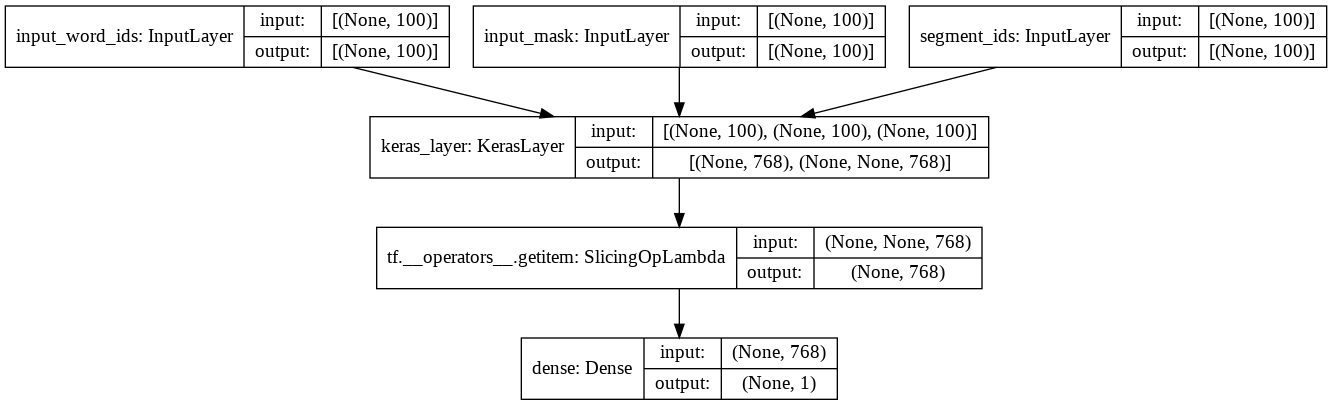

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

On a bien **un modèle à trois entrées** qui se rejoignent pour former **réseau de couches uniques**.

Le modèle peut sembler simple de prime abord mais il faut bien comprendre que dans la **couche KerasLayer** (la couche de BERT) il y a en fait **plusieurs autres couches**.

Elle ne sont **pas visible** ici car elles sont chargé depuis **TensorFlow Hub** mais le nom du modèle parle de lui même : "*bert_en_uncased_L-12_H-768_A-12*"

- **L-12** : 12 couches caché (12 Layers)
- **H-768** : une "taille caché" de 768, en fait 768 neurones (768 Hidden size)
- **A-12** : 12 module d'Attention, ces modules servent à faire des calcules en parallèles (12 attention head)

De plus on a **en_uncase**, cela veut dire que le texte a été mis en minuscules pendant **le preprocessing**.

Nous irons plus amplement dans le détail dans **un prochain article sur BERT et les transformers**.

En attendant, **entraînons notre modèle !**

## **Transfer Learning**

In [ ]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=5,
    batch_size=32
)

Epoch 1/5
375/375 [==============================] - 267s 671ms/step - loss: 0.6241 - accuracy: 0.6751 - val_loss: 0.3952 - val_accuracy: 0.8187
Epoch 2/5
375/375 [==============================] - 252s 673ms/step - loss: 0.3396 - accuracy: 0.8490 - val_loss: 0.3418 - val_accuracy: 0.8540
Epoch 3/5
375/375 [==============================] - 252s 673ms/step - loss: 0.2687 - accuracy: 0.8870 - val_loss: 0.3324 - val_accuracy: 0.8603
Epoch 4/5
375/375 [==============================] - 252s 672ms/step - loss: 0.2090 - accuracy: 0.9236 - val_loss: 0.3545 - val_accuracy: 0.8510
Epoch 5/5
375/375 [==============================] - 252s 671ms/step - loss: 0.1628 - accuracy: 0.9452 - val_loss: 0.3677 - val_accuracy: 0.8587


Mais attendez... **pourquoi entraînons-nous notre modèle si BERT est déjà préentraîné ?**

Effectivement, **les poids des neurones de BERT** sont entraînés mais pas **les poids des nouvelles couches !**

Il faut donc effectuer **un entraînement sur tout le modèle**. Les nouvelles couches vont alors **s'adapter aux poids de BERT**.

C'est ce qu'on appelle le **Transfer Learning**, cette technique est largement répandu dans le Machine Learning car elle permet **d'adapter des modèles** déjà entraînés à de **nouveaux problème**.

En fait, **Google a entraîner BERT** sur de nombreuses données pendant des heures. Le Transfer Learning permet de **poursuivre cet entraînement sur nos données**, tout en nous évitant les heures d'apprentissage déjà effectué !

## **Utiliser BERT**

Notre **BERT est entraîné** pour la classification binaire !

On peut donc l'évaluer avec **nos données de test :**

In [ ]:
model.evaluate(test_input, test_labels)

157/157 [==============================] - 34s 215ms/step - loss: 0.3863 - accuracy: 0.8474


[0.3863307535648346, 0.8474000096321106]

**Une loss de 0.38** et **une précision 0.84**, c'est plutôt pas mal.. même **très bon** vu le nombre de données que l'on a !

Essayons avec **nos propres phrases**.

Commençons avec un exemple facile "*J'ai aimé ce film*" :

In [ ]:
model.predict(bert_encode(["I liked this movie"], tokenizer, max_len=100))

array([[0.63292855]], dtype=float32)

BERT juge notre phrase positive avec **précision de 0.63**. Il n'a pas l'air très sûr de lui alors **la phrase semble pourtant évidente**.

Essayons avec une phrase un peu plus complexe "*Tout était parfait, sauf le film !*".

In [ ]:
model.predict(bert_encode(["Everything was fine but not the movie !"], tokenizer, max_len=100))

array([[0.0498449]], dtype=float32)

Ici **BERT** est sûr à presque **100%** que la phrase parle négativement du film, comme quoi, **cela dépend vraiment de l'input qu'on lui donne !**

Finalement, on peut **sauvegarder le BERT adapté à nos données :**

In [ ]:
model.save('/content/model.h5')

Et voilà le code pour le **charger dans un autre programme sans avoir à le réentraîner :**

In [ ]:
#from tensorflow import keras
#model = keras.models.load_model('/content/model.h5')